In [21]:
import json
from pathlib import Path
from typing import Sequence, TypeAlias

import numpy as np
from matplotlib import pyplot as plt

from gossiplearning import History

N_SIMULATIONS = 10
N_NODES = 10
N_STEPS = 20
STEP_SIZE = 5

colors = ["blue", "green", "orange", "red", "purple"]

MSE: TypeAlias = float
Variance: TypeAlias = float

experiments = {
    # NOT SCALED

    # "porto_80": "Weighted Overwrite",
    # "porto_82": "Simple Average",
    # "porto_83": "Overwrite",
    # "porto_84": "Weighted Average",
    # "porto_86": "Avg 0.2",
    # "porto_87": "WAvg 0.2",
    # "porto_88": "Ovw Opt",
    # "porto_89": "impOvw opt",
    
    # 1k
    "porto_94": "Overwrite",
    "porto_95": "Weighted Overwrite",
    "porto_96": "Simple Average",
    "porto_97": "Weighted Average",
}

histories = {
    exp: []
    for exp in experiments.keys()
}

for i in range(N_SIMULATIONS):
    for exp in experiments.keys():
        with open(f"experiments/{exp}/{i}/history.json", "r") as f:
             histories[exp].append(History(**json.load(f)))

In [22]:
def get_node_mses_by_epoch(history: History) -> Sequence[Sequence[MSE]]:
    nodes_test_mses = [
        test_history["mse"]
        for test_history in history.nodes_test_history.values()
    ]
    
    epochs_mses = [
        [nodes_test_mses[node][step] for node in range(N_NODES)]
        for step in range(N_STEPS)
    ]
    
    return epochs_mses

In [23]:
mse = {
    exp: [
        get_node_mses_by_epoch(history)
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

In [24]:
def get_variances(mses: Sequence[Sequence[Sequence[MSE]]]) -> Sequence[Sequence[Variance]]:
    return [
        [
            (np.std(mses[sim][step]) * 100) / np.mean(mses[sim][step])
            # np.std(mses[sim][step])
            for step in range(N_STEPS)
        ]
        for sim in range(N_SIMULATIONS)
    ]

def get_averages(mses: Sequence[Sequence[Sequence[MSE]]]) -> Sequence[Sequence[MSE]]:
    return [[np.average(mses[sim][step]) for step in range(N_STEPS)] for sim in range(N_SIMULATIONS)]

In [25]:
variances = {
    exp: get_variances(mse[exp])
    for exp in experiments.keys()
}

averages = {
    exp: get_averages(mse[exp])
    for exp in experiments.keys()
}

In [26]:
def get_min_max_mean_series(series: Sequence[Sequence[float]]) -> tuple[Sequence[float], Sequence[float], Sequence[float]]:
    s_len = len(series)
    step_len = len(series[0])
    
    # means = [
    #     np.median([series[i][j] for i in range(s_len)])
    #     for j in range(step_len)
    # ]
    # 
    # mins = [
    #     np.quantile([series[i][j] for i in range(s_len)], q=0.25)
    #     for j in range(step_len)
    # ]
    # 
    # maxs = [
    #     np.quantile([series[i][j] for i in range(s_len)], q=0.75)
    #     for j in range(step_len)
    # ]
    
    means = [sum(series[i][j] for i in range(s_len)) / s_len for j in range(step_len)]
    mins = [min(series[i][j] for i in range(s_len)) for j in range(step_len)]
    maxs = [max(series[i][j] for i in range(s_len)) for j in range(step_len)]
    
    return means, mins, maxs

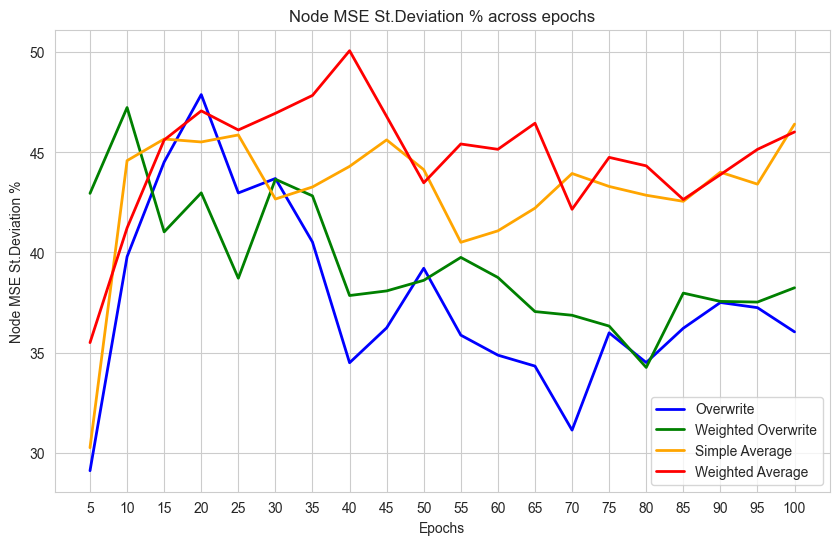

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

index = list(range(N_STEPS))
x_ticks = [(x+1)*STEP_SIZE for x in index]

for exp, color in zip(experiments.keys(), iter(colors)):
    mean, low, high = get_min_max_mean_series(variances[exp])
    ax.plot(mean, linewidth=2, label=experiments[exp], color=color)
    # ax.fill_between(index, low, high, alpha=0.1, color=color)
# ax.set_yscale("log")
ax.set_title("Node MSE St.Deviation % across epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Node MSE St.Deviation %")

ax.set_xticks(index, labels=x_ticks)
ax.legend()

plt.show()
fig.savefig("test.svg", format="svg", dpi=500)

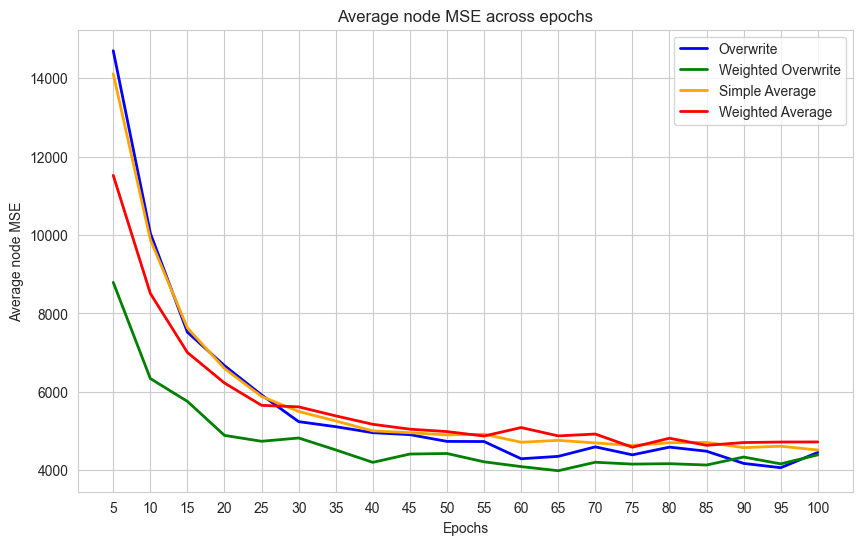

In [30]:

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,6))

index = list(range(N_STEPS))
x_ticks = [(x+1)*STEP_SIZE for x in index]

for exp, color in zip(experiments.keys(), iter(colors)):
    mean, low, high = get_min_max_mean_series(averages[exp])
    ax.plot(mean, linewidth=2, label=experiments[exp], color=color)
    # ax.fill_between(index, low, high, alpha=0.1, color=color)

ax.set_title("Average node MSE across epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Average node MSE")
# ax.set_yscale("log")
ax.set_xticks(index, labels=x_ticks)
ax.legend()

Path("plots/speed").mkdir(parents=True, exist_ok=True)
plt.savefig("plots/speed/merge_strategies_1k.svg", format="svg", dpi=500, bbox_inches='tight')